<a href="https://colab.research.google.com/github/rudraxx/pytorch/blob/main/07_VAE_pytorch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
!pip install umap-learn
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nv

In [59]:

# https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb

import torch
import torch.nn as nn
from torchsummary import summary

from torchviz import make_dot
import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from sklearn.manifold import TSNE
# from umap import UMAP
import umap




In [8]:
DEVICE='cuda' if torch.cuda.is_available() else 'cpu'

print(f"Device set to : {DEVICE}")



Device set to : cuda


In [9]:
# Model Hyperparameters

dataset_path = '~/datasets'

# cuda = True
# DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 128

hidden_dim = 2048 # For the intermediate Linear layer
latent_dim = 10 # Mean and log(Var) will be of this size each
input_channels = 1
# CNN_channels =

lr = 1e-3
epochs = 30

In [10]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

# kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)#, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)#, **kwargs)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 3590035.36it/s]


Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 491909.61it/s]


Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3981109.23it/s]


Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4426238.10it/s]

Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



In [14]:
# What is the size of the incoming data?
images, target = next(iter(train_loader))
print(f"images.shape={images.shape}")
print(f"target.shape={target.shape}")

INPUT_W,INPUT_H = images.shape[2], images.shape[3]


images.shape=torch.Size([128, 1, 28, 28])
target.shape=torch.Size([128])


In [55]:
"""
    A simple implementation of CNN Encoder and Decoder
"""

class Encoder(nn.Module):

    def __init__(self, in_channels, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.latent_dim = latent_dim

        channel_sizes = [16,32,64,128, 256]
        # print(f"in_channels={in_channels}")

        module_list = []
        curr_channels = in_channels #Set the input_channels for first layer

        for ch in channel_sizes:

          if ch>32:
            curr_stride=2
          else:
            curr_stride=1

          module = nn.Sequential(
            nn.Conv2d(curr_channels, ch, kernel_size=3, stride=curr_stride),
            nn.BatchNorm2d(ch),
            nn.LeakyReLU(),
          )
          module_list.append(module)
          #Update the in_channels
          curr_channels = ch

        #Create the encoder stage
        self.encoder = nn.Sequential(*module_list)

        # self.encoder = nn.Sequential(
        #     nn.Conv2d(in_channels, 16, kernel_size=4),
        #     nn.BatchNorm2d()
        #     nn.ReLU(),
        #     nn.Conv2d(16, 32, kernel_size=4),
        #     nn.ReLU(),
        #     nn.Conv2d(32, 64, kernel_size=4, stride=2),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 128, kernel_size=4, stride=2),
        #     nn.ReLU(),
        #     # nn.Conv2d(128, 256, kernel_size=4, stride=2),
        #     # nn.ReLU(),
        # )

        self.flatten = nn.Flatten()

        # fully connected layer to transform the flattened vecotr into latent space size
        # self.FC_input = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = None # nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = None # nn.Linear (hidden_dim, latent_dim)

        # self.LeakyReLU = nn.LeakyReLU(0.2)

        # self.training = True

    def forward(self, x):
        x  = self.encoder(x)
        # print(x.shape)
        x = self.flatten(x)
        print(f"after flatten shape: {x.shape}")

        # # Convert the flattened vector into the mean and log_var
        #Dynamically define the size of this layer
        if self.FC_mean is None:
          #Init the size in the first pass
          self.FC_mean = nn.Linear(x.shape[1], self.latent_dim)  # x.shape[1] is the flattened size
          self.FC_var  = nn.Linear(x.shape[1], self.latent_dim)  # x.shape[1] is the flattened size


        mean     = self.FC_mean(x)
        log_var  = self.FC_var(x)                     # encoder produces mean and log of variance
        #                                                #             (i.e., parateters of simple tractable normal distribution "q"
        return mean, log_var

        # return torch.randn(x.shape[0],10), torch.randn(x.shape[0],10)

In [56]:
#Test the size
xin = torch.randn(batch_size, input_channels, INPUT_W,INPUT_H)
enc = Encoder(input_channels,hidden_dim, latent_dim)
x = enc(xin)

print(f"Shape of the mu output of the encoder: {x[0].shape}")
print(f"Shape of the log_var of the encoder: {x[1].shape}")


after flatten shape: torch.Size([128, 1024])
Shape of the mu output of the encoder: torch.Size([128, 10])
Shape of the log_var of the encoder: torch.Size([128, 10])


In [57]:
#Also show the model summary
summary(enc.to(DEVICE), (1,28,28))



after flatten shape: torch.Size([2, 1024])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
         LeakyReLU-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 32, 24, 24]           4,640
       BatchNorm2d-5           [-1, 32, 24, 24]              64
         LeakyReLU-6           [-1, 32, 24, 24]               0
            Conv2d-7           [-1, 64, 11, 11]          18,496
       BatchNorm2d-8           [-1, 64, 11, 11]             128
         LeakyReLU-9           [-1, 64, 11, 11]               0
           Conv2d-10            [-1, 128, 5, 5]          73,856
      BatchNorm2d-11            [-1, 128, 5, 5]             256
        LeakyReLU-12            [-1, 128, 5, 5]               0
           Conv2d-13            [-1, 256, 2, 2]         295,

In [60]:
#Show as a graph
dot = make_dot(x, params=dict(enc.named_parameters()))

# Save or render the graph
dot.render("model_diagram", format="png")

'model_diagram.png'

In [ ]:
# print(128*16)

In [ ]:
# Decoder will take the mu,var values and convert that to the image size
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, input_channels):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Unflatten(-1,(128,4,4)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, input_channels, kernel_size=4, stride=1),
            # nn.Conv2d()
            nn.Sigmoid()
        )

        # Convert the reparameterized mu + var*eps into the right vector size
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)

        # self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
      x = self.FC_hidden(x)
      x = self.decoder(x)

      return x

        # h     = self.LeakyReLU(self.FC_hidden(x))
        # h     = self.LeakyReLU(self.FC_hidden2(h))

        # x_hat = torch.sigmoid(self.FC_output(h))
        # return x_hat


In [ ]:
# Test decoder shape
decoder = Decoder(latent_dim, hidden_dim, input_channels)

x = torch.rand(batch_size, latent_dim)

x= decoder(x)
print(f"Decoded output size: {x.shape}")

Decoded output size: torch.Size([128, 1, 28, 28])


In [ ]:
class VAE_CNN(nn.Module):
  def __init__(self, encoder, decoder):
    super(VAE_CNN, self).__init__()

    self.encoder = encoder
    self.decoder = decoder

  def forward(self, x):

    #Run through the encoder
    mu, log_var = self.encoder(x)

    #Reparameterize the variables:
    #  z = mu + randn * std
    std_dev = torch.exp(0.5*log_var)
    eps = torch.randn_like(std_dev)

    z = mu + torch.mul(eps, std_dev) #Convert log(var) to std dev

    # Go through the decoder
    x_hat = decoder(z)

    return mu, log_var, x_hat



In [ ]:
encoder = Encoder(input_channels,hidden_dim, latent_dim)

decoder = Decoder(latent_dim, hidden_dim, input_channels)

vae_model = VAE_CNN(encoder, decoder)

#Test the model
x = torch.randn(batch_size, 1, 28,28)

mu, log_var, x_hat = vae_model(x)

print(f"vae return shape: {x_hat.shape}")

vae return shape: torch.Size([128, 1, 28, 28])


In [ ]:
#Test broadcast multiplication
# eps = torch.randn([batch_size, latent_dim])
# x = torch.randn([batch_size, latent_dim])

# print(torch.mul(x, eps).shape)

In [ ]:
# class Model(nn.Module):
#     def __init__(self, Encoder, Decoder):
#         super(Model, self).__init__()
#         self.Encoder = Encoder
#         self.Decoder = Decoder

#     def reparameterization(self, mean, var):
#         epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon
#         z = mean + var*epsilon                          # reparameterization trick
#         return z


#     def forward(self, x):
#         mean, log_var = self.Encoder(x)
#         z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
#         x_hat            = self.Decoder(z)

#         return x_hat, mean, log_var

In [ ]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(vae_model.parameters(), lr=lr)

In [ ]:
print("Start training VAE...")
vae_model.to(DEVICE)

vae_model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        #Move to device
        x = x.to(DEVICE)

        optimizer.zero_grad()

        mu, log_var, x_hat = vae_model(x)
        loss = loss_function(x, x_hat, mu, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  163.3870050968268
	Epoch 2 complete! 	Average Loss:  112.722990981534
	Epoch 3 complete! 	Average Loss:  108.36047653459076
	Epoch 4 complete! 	Average Loss:  106.23412267570822
	Epoch 5 complete! 	Average Loss:  104.85600978492671
	Epoch 6 complete! 	Average Loss:  103.91583992069603
	Epoch 7 complete! 	Average Loss:  103.12650771833893
	Epoch 8 complete! 	Average Loss:  102.51209844279494
	Epoch 9 complete! 	Average Loss:  101.9902101174379
	Epoch 10 complete! 	Average Loss:  101.48644093570546
	Epoch 11 complete! 	Average Loss:  101.0870847783537
	Epoch 12 complete! 	Average Loss:  100.72430783459264
	Epoch 13 complete! 	Average Loss:  100.40707560482188
	Epoch 14 complete! 	Average Loss:  100.1376511500432
	Epoch 15 complete! 	Average Loss:  99.91752842960194
	Epoch 16 complete! 	Average Loss:  99.59823473090799
	Epoch 17 complete! 	Average Loss:  99.44574581048427
	Epoch 18 complete! 	Average Loss:  99.25087292989095
	Epoch 

In [ ]:
#Create some reconstructed examples based on test data +  trained model
import matplotlib.pyplot as plt
vae_model.eval()

with torch.no_grad():
    for batch_idx, (x, targets) in enumerate(tqdm(test_loader)):

        x = x.to(DEVICE)

        mu_eval, log_var_eval, x_hat = vae_model(x)

        break




  0%|          | 0/79 [00:00<?, ?it/s]


In [ ]:
print(torch.min(mu_eval))

tensor(-3.5432, device='cuda:0')


In [ ]:
#Function to plot specific samples
def show_image(x, targets, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

    if targets is not None:
      true_tgt = targets[idx].item()

      plt.title(f"Actual target: {true_tgt}")


In [ ]:
print(x_hat.shape)

torch.Size([128, 1, 28, 28])


torch.Size([128, 1, 28, 28])


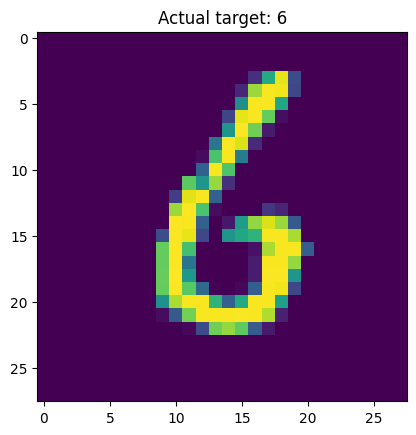

In [ ]:
print(x.shape)
show_image(x, targets, idx=50)


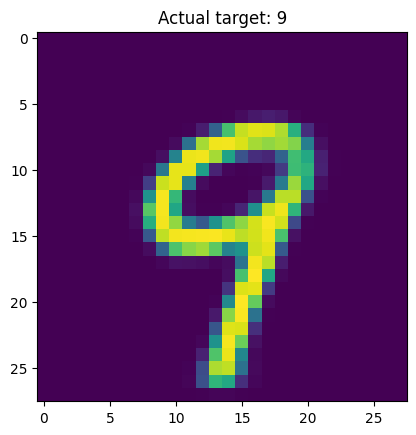

In [ ]:
show_image(x_hat, targets, idx=12)


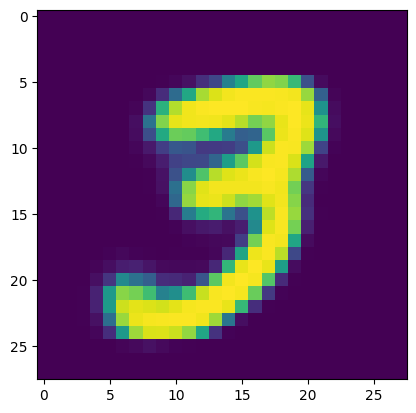

In [ ]:
#Step 6. Generate image from noise vector
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)
# save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')
show_image(generated_images, None, idx=12)

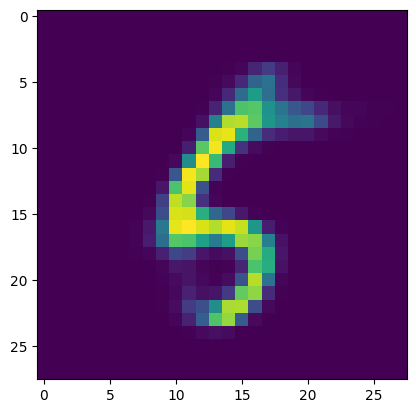

In [ ]:
show_image(generated_images, None, idx=33)


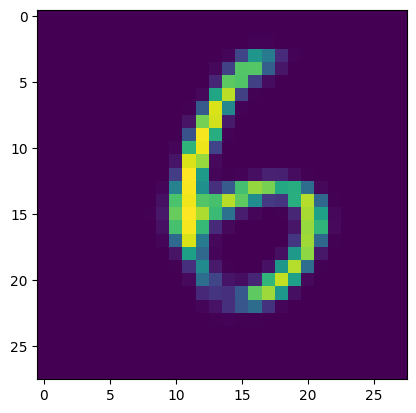

In [ ]:
show_image(generated_images, None, idx=0)


generated_images.shape = torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28]) torch.Size([3, 392, 302])


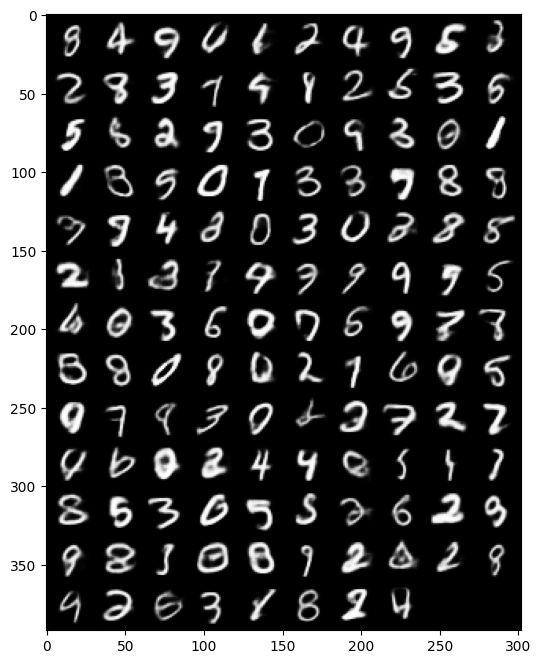

In [ ]:
#Show grid of the generated images
print(f"generated_images.shape = {generated_images.shape}")
# g2 = generated_images.view(batch_size, 28,28).unsqueeze(1)
# print(f"generated_images.shape after unsqueeze = {g2.shape}")
res = make_grid(generated_images,nrow=10)
# res = res.permute(1,2,0)
print(generated_images.shape, res.shape)


# new_image = make_grid(g2.cpu(), nrow=4)
# print(new_image.shape)
plt.figure(figsize=(8,8))
plt.imshow(res.permute(1,2,0).cpu())

In [ ]:
def show_images_grid(images, title):

  res = make_grid(images,nrow=12)
  res = res.permute(1,2,0)

  plt.figure(figsize=(10,10))
  plt.imshow(res)
  plt.show()
  plt.title(title)

In [ ]:
import plotly.express as px

def visualize_latent_space(model, data_loader, device, method='TSNE', num_samples=10000):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for i, (data, label) in enumerate(data_loader):
          if len(latents) > num_samples:
            break
          # print(f"i:", i, "len(latents)", len(latents))

          # print(f"data.shape:", data.shape)
          # mu, _ = encoder(data.to(device))
          mu, log_var, x_hat = model(data.to(device))
          # print(f"sizes:", x_hat.shape, mu.shape, log_var.shape)

          latents.append(mu.cpu())
          labels.append(label.cpu())

    latents = torch.cat(latents, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    assert method in ['TSNE', 'UMAP'], 'method should be TSNE or UMAP'
    if method == 'TSNE':
        tsne = TSNE(n_components=2, verbose=1)
        tsne_results = tsne.fit_transform(latents)
        fig = px.scatter(tsne_results, x=0, y=1, color=labels, labels={'color': 'label'})
        fig.update_layout(title='VAE Latent Space with TSNE',
                          width=600,
                          height=600)
    elif method == 'UMAP':
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(latents)
        fig = px.scatter(embedding, x=0, y=1, color=labels, labels={'color': 'label'})

        fig.update_layout(title='VAE Latent Space with UMAP',
                          width=600,
                          height=600
                          )

    fig.show()


In [ ]:
visualize_latent_space(vae_model, train_loader,
                       device=DEVICE,
                       method='UMAP', num_samples=10000)



In [ ]:
print(mu_eval.shape)

torch.Size([100, 10])
